In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv


In [2]:
from datetime import datetime

# Define the dateparse function using datetime.strptime
def dateparse(dates):
    return datetime.strptime(dates, '%Y-%m-%d')

# Read the CSV data using pandas with the dateparse function
data = pd.read_csv('../input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

market_data = pd.read_csv('/kaggle/input/s-and-p-500-data-for-comparison/Market_data.csv')


In [3]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.4 MB/s eta 0:00:00


In [4]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


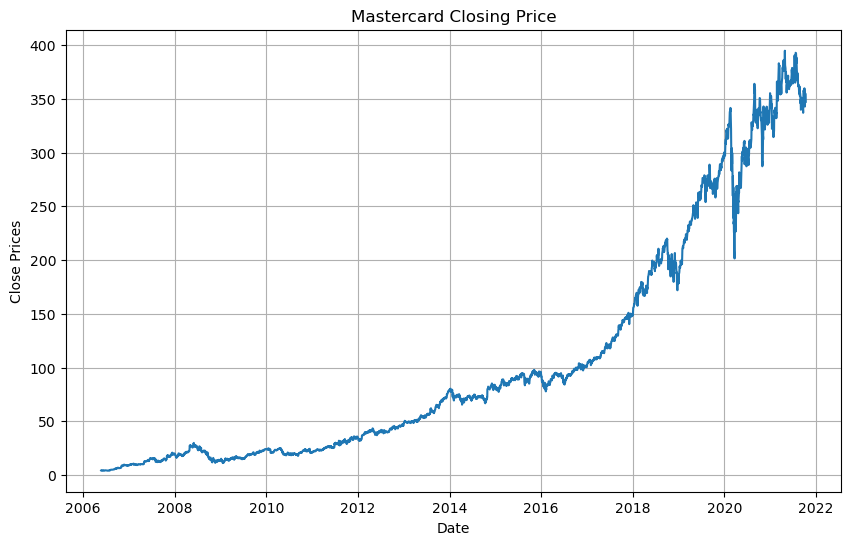

In [5]:
#Visualize the stock’s daily closing price.

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Mastercard Closing Price')
plt.show()

<Axes: ylabel='Density'>

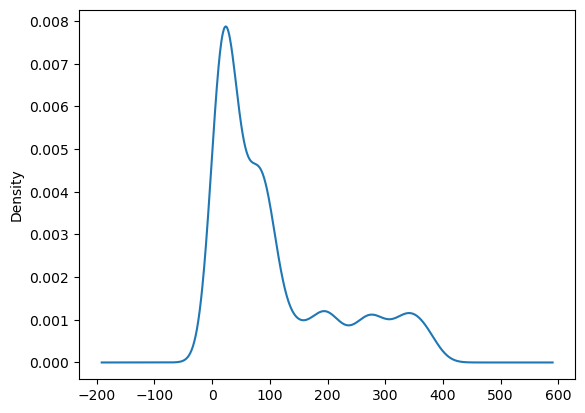

In [6]:
#Distribution of the dataset
df_close = data['Close']
df_close.plot(kind='kde')

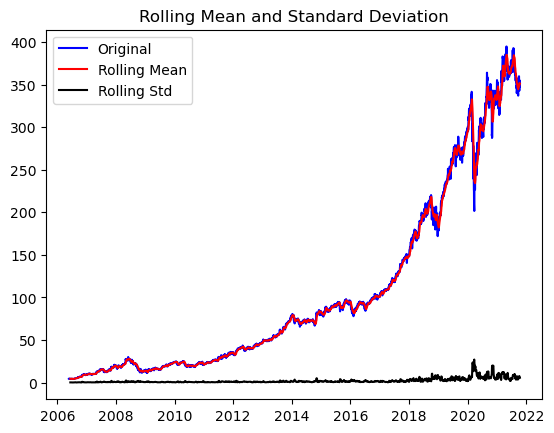

Results of Augmented Dickey-Fuller Test:
Test Statistics                   1.203926
p-value                           0.996013
No. of Lags Used                 28.000000
Number of Observations Used    3843.000000
Critical Value (1%)              -3.432053
Critical Value (5%)              -2.862292
Critical Value (10%)             -2.567171
dtype: float64

Results of KPSS Test:
Test Statistics           8.057294
p-value                   0.010000
Number of Lags Used      39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_20/2407355754.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(timeseries, regression='c', nlags='auto')


In [7]:
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Augmented Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

    print("\nResults of KPSS Test:")
    kpss_test = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

test_stationarity(df_close)


Both the Augmented Dickey-Fuller Test and KPSS Test indicate that the time series data is non-stationary. This means that the data requires differencing or other transformations to make it suitable for ARIMA modeling, as ARIMA assumes stationary data.

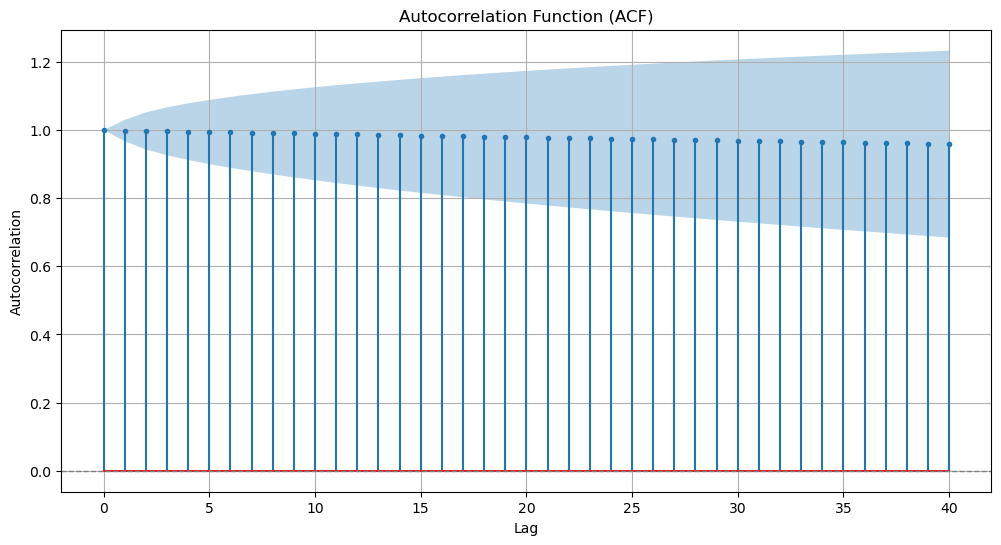

ACF Values:
Lag 0: ACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: ACF Value = 0.9988437189595502, Confidence Interval = [0.9673459  1.03034153]
Lag 2: ACF Value = 0.9977314128356216, Confidence Interval = [0.94321764 1.05224518]
Lag 3: ACF Value = 0.9965952125752459, Confidence Interval = [0.92626042 1.06693   ]
Lag 4: ACF Value = 0.9955063671490026, Confidence Interval = [0.91233354 1.07867919]
Lag 5: ACF Value = 0.9945077978373202, Confidence Interval = [0.90025202 1.08876357]
Lag 6: ACF Value = 0.9935112874482287, Confidence Interval = [0.88936409 1.09765849]
Lag 7: ACF Value = 0.9925187188708945, Confidence Interval = [0.87935867 1.10567877]
Lag 8: ACF Value = 0.9914976467626304, Confidence Interval = [0.87000755 1.11298775]
Lag 9: ACF Value = 0.9905018063007563, Confidence Interval = [0.86123282 1.11977079]
Lag 10: ACF Value = 0.9894464955526029, Confidence Interval = [0.8528552  1.12603779]
Lag 11: ACF Value = 0.9883812387211224, Confidence Interval = [0.84485512 1.1319073

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf


# Calculate ACF and PACF values
acf_values, confint_acf = acf(data['Close'], nlags=40, alpha=0.05)

# Plot ACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(acf_values)), confint_acf[:, 0], confint_acf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Print ACF values with confidence intervals
print("ACF Values:")
for lag, acf_val, conf_int in zip(range(len(acf_values)), acf_values, confint_acf):
    print(f"Lag {lag}: ACF Value = {acf_val}, Confidence Interval = {conf_int}")


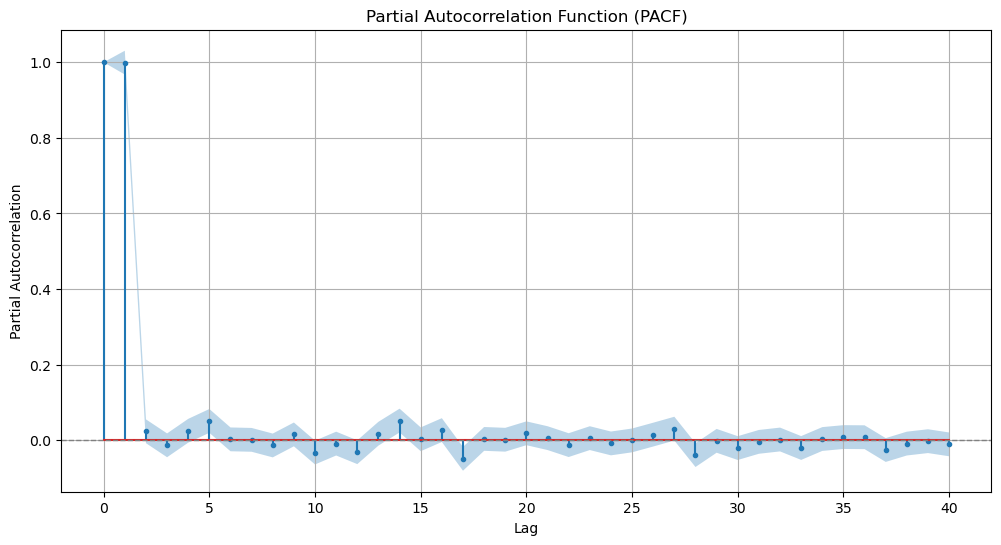

PACF Values:
Lag 0: PACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: PACF Value = 0.9991017514366778, Confidence Interval = [0.96760394 1.03059957]
Lag 2: PACF Value = 0.023793959079472304, Confidence Interval = [-0.00770386  0.05529177]
Lag 3: PACF Value = -0.01341087142366341, Confidence Interval = [-0.04490869  0.01808694]
Lag 4: PACF Value = 0.02508586581127185, Confidence Interval = [-0.00641195  0.05658368]
Lag 5: PACF Value = 0.051154973398887665, Confidence Interval = [0.01965716 0.08265279]
Lag 6: PACF Value = 0.0023631392280840232, Confidence Interval = [-0.02913467  0.03386095]
Lag 7: PACF Value = 0.0010560401175935155, Confidence Interval = [-0.03044177  0.03255385]
Lag 8: PACF Value = -0.01382340364465352, Confidence Interval = [-0.04532122  0.01767441]
Lag 9: PACF Value = 0.015443524028389782, Confidence Interval = [-0.01605429  0.04694134]
Lag 10: PACF Value = -0.03252863127485632, Confidence Interval = [-0.06402645 -0.00103082]
Lag 11: PACF Value = -0.008840716670

In [9]:
pacf_values, confint_pacf = pacf(data['Close'], nlags=40, alpha=0.05)

# Plot PACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(pacf_values)), confint_pacf[:, 0], confint_pacf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Print PACF values with confidence intervals
print("PACF Values:")
for lag, pacf_val, conf_int in zip(range(len(pacf_values)), pacf_values, confint_pacf):
    print(f"Lag {lag}: PACF Value = {pacf_val}, Confidence Interval = {conf_int}")

<Figure size 640x480 with 0 Axes>

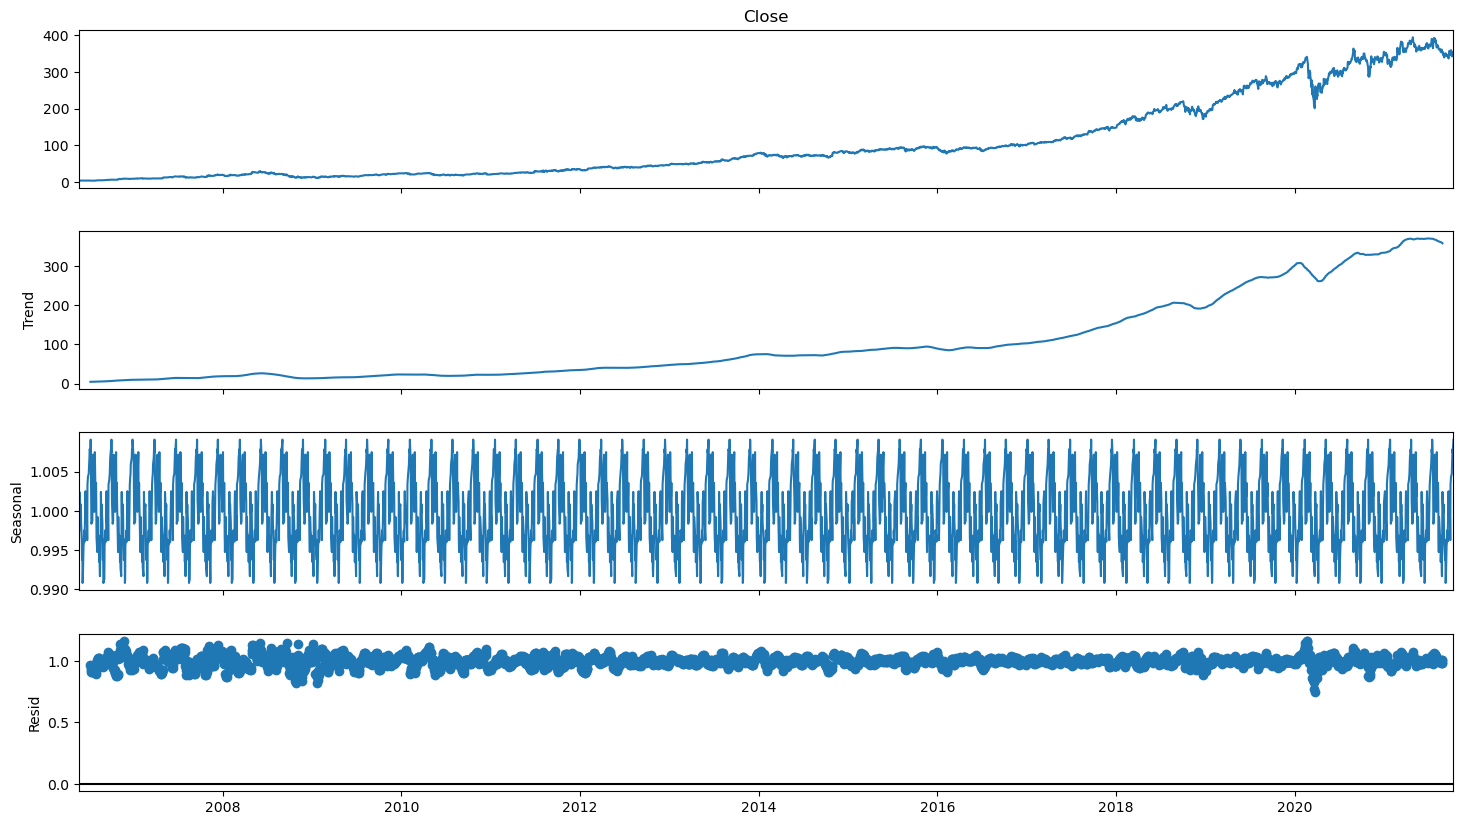

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's isolate the time series from the Trend and Seasonality.
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(data['Close'], model='multiplicative', period=60)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()


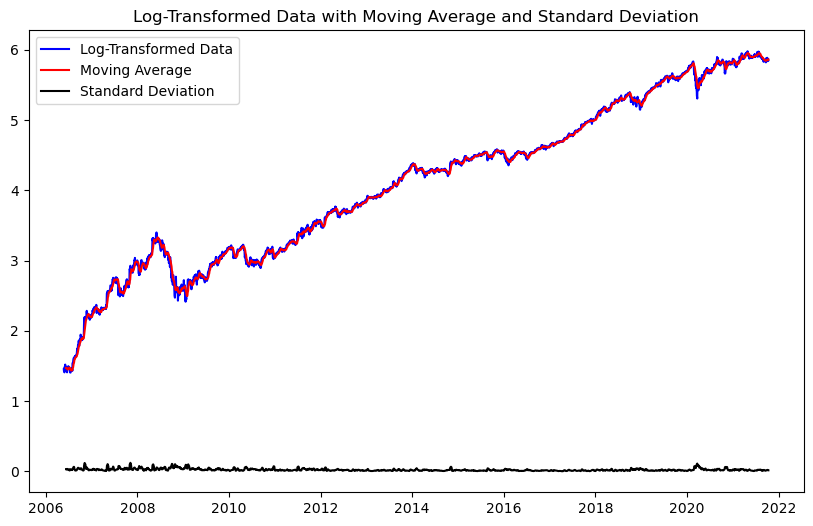

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Take the log transformation
df_log = np.log(df_close)

# Calculate the moving average
moving_avg = df_log.rolling(12).mean()

# Calculate the standard deviation
std_dev = df_log.rolling(12).std()

# Plot the original log-transformed data, moving average, and standard deviation
plt.plot(df_log, color='blue', label='Log-Transformed Data')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Log-Transformed Data with Moving Average and Standard Deviation')
plt.show()


<Figure size 1000x600 with 0 Axes>

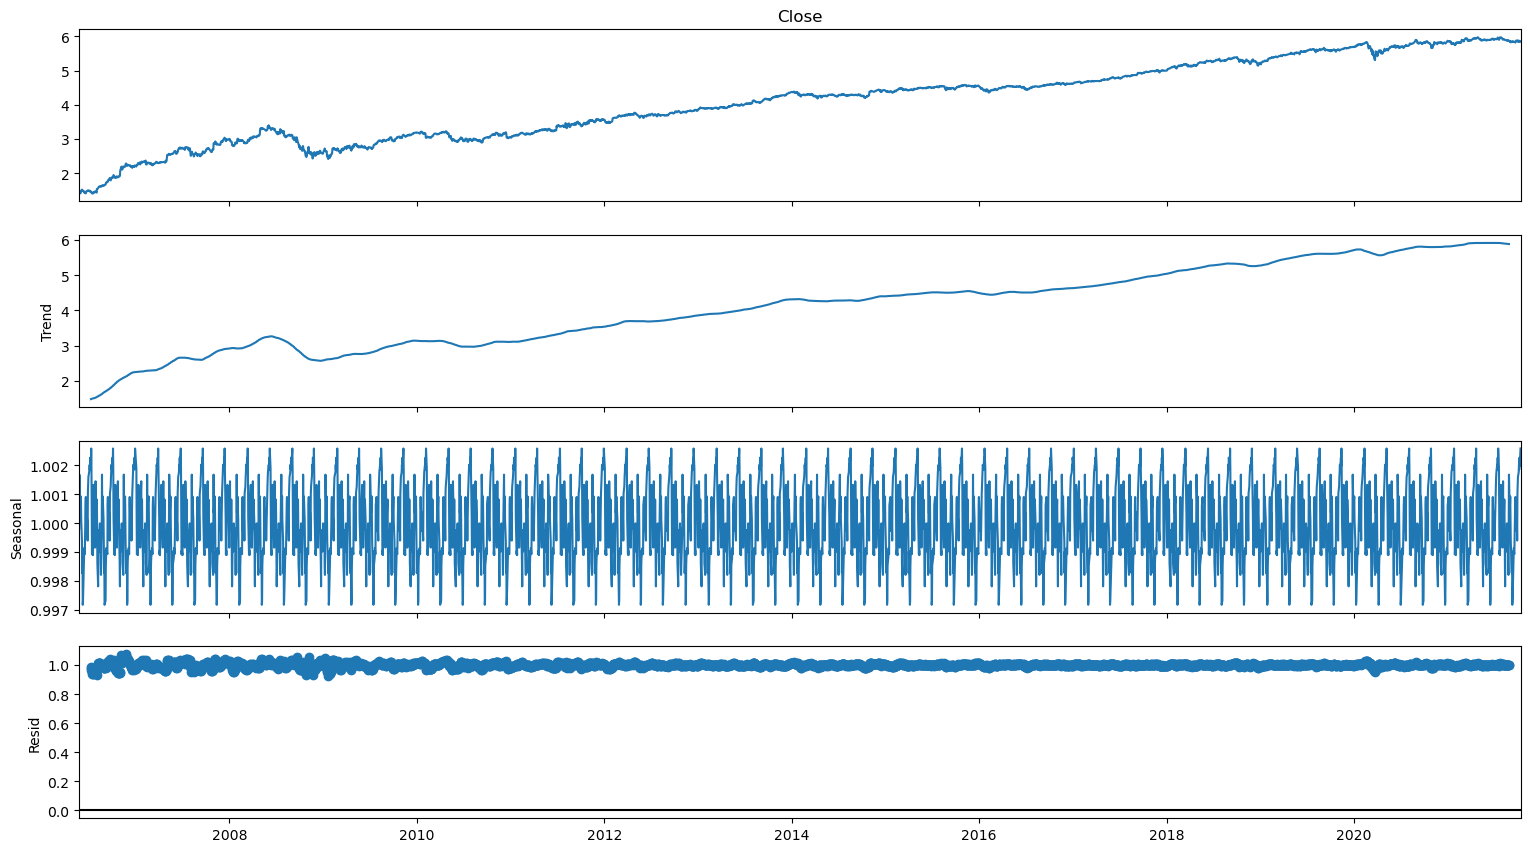

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Let's isolate the time series from the Trend and Seasonality.
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_log, model='multiplicative', period=60)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

In [13]:
def adf_test(series):
    """
    Perform Augmented Dickey-Fuller test and return the results.
    """
    result = adfuller(series, autolag='AIC')
    adf_output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in result[4].items():
        adf_output['Critical Value (%s)' % key] = value

    return adf_output

def kpss_test(series):
    """
    Perform KPSS test and return the results.
    """
    result = kpss(series, regression='c', nlags='auto')
    kpss_output = pd.Series(result[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
    for key, value in result[3].items():
        kpss_output['Critical Value (%s)' % key] = value

    return kpss_output

# Apply the ADF test to the 'Close' column
adf_output = adf_test(df_log)

# Apply the KPSS test to the log-transformed 'Close' column
kpss_output = kpss_test(df_log)

# Check for stationarity using ADF test
signif = 0.05
p_value = adf_output['p-value']

print("Results of Augmented Dickey-Fuller Test:")
print(adf_output)

if p_value <= signif:
    print(f"ADF test indicates that the series 'Close' is stationary.")
else:
    print(f"ADF test indicates that the series 'Close' is non-stationary.")

# Check for stationarity using KPSS test
p_value_kpss = kpss_output['p-value']

print("\nResults of KPSS Test:")
print(kpss_output)

if p_value_kpss >= signif:
    print(f"KPSS test indicates that the series 'Close' is stationary.")
else:
    print(f"KPSS test indicates that the series 'Close' is non-stationary.")


Results of Augmented Dickey-Fuller Test:
Test Statistics                  -2.108513
p-value                           0.241105
No. of Lags Used                 18.000000
Number of Observations Used    3853.000000
Critical Value (1%)              -3.432048
Critical Value (5%)              -2.862290
Critical Value (10%)             -2.567169
dtype: float64
ADF test indicates that the series 'Close' is non-stationary.

Results of KPSS Test:
Test Statistics           9.504541
p-value                   0.010000
Number of Lags Used      39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS test indicates that the series 'Close' is non-stationary.


/tmp/ipykernel_20/3839066479.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


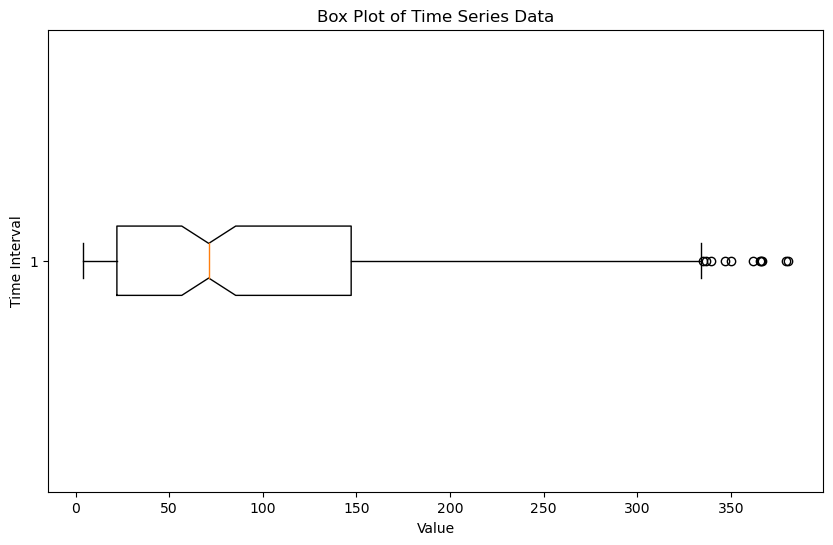

Outlier Values:
172    335.284414
175    336.789767
177    339.496572
178    365.381231
179    379.682139
180    365.971404
181    366.899999
182    380.526351
183    362.025769
184    346.936890
185    350.076861
Name: Close, dtype: float64


In [14]:
# Resample the data and reset the index
resampled_data = data.resample('M').mean().reset_index()

plt.figure(figsize=(10, 6))
plt.boxplot(resampled_data['Close'], notch=True, vert=False)
plt.title('Box Plot of Time Series Data')
plt.xlabel('Value')
plt.ylabel('Time Interval')
plt.show()

# Identify and print outlier values
q1 = resampled_data['Close'].quantile(0.25)
q3 = resampled_data['Close'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = resampled_data[(resampled_data['Close'] < lower_bound) | (resampled_data['Close'] > upper_bound)]['Close']
print("Outlier Values:")
print(outliers)



In [15]:
# Drop outliers from the DataFrame
df_without_outliers = resampled_data.drop(outliers.index)


In [16]:
import scipy.stats as stats

# Check if 'Close' column contains any non-positive values
if (df_without_outliers['Close'] <= 0).any():
    # If any value is non-positive, add a small positive value to make them positive
    df_without_outliers['Close'] = df_without_outliers['Close'] + 0.001

# Apply Box-Cox transformation
df_without_outliers['Close_transformed'], lambda_val = stats.boxcox(df_without_outliers['Close'])

# Print the lambda value used in the transformation
print("Lambda value:", lambda_val)


Lambda value: 0.0591748041008843


In [17]:
df_without_outliers.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_transformed
0,2006-05-31,4.091304,4.258984,3.988742,4.183167,1.445718e+08,0.0,0.0,1.493410
1,2006-06-30,4.349791,4.418757,4.273467,4.349283,2.183009e+07,0.0,0.0,1.535842
2,2006-07-31,4.267356,4.300474,4.218285,4.257495,8.656400e+06,0.0,0.0,1.512588
3,2006-08-31,4.928380,5.010810,4.888055,4.954589,1.157304e+07,0.0,0.0,1.678537
4,2006-09-30,5.859737,6.002160,5.778664,5.925599,2.016965e+07,0.0,0.0,1.876327


In [18]:

def adf_test(series):
    """
    Perform Augmented Dickey-Fuller test and return the results.
    """
    result = adfuller(series, autolag='AIC')
    adf_output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in result[4].items():
        adf_output['Critical Value (%s)' % key] = value

    return adf_output

def kpss_test(series):
    """
    Perform KPSS test and return the results.
    """
    result = kpss(series, regression='c', nlags='auto')
    kpss_output = pd.Series(result[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
    for key, value in result[3].items():
        kpss_output['Critical Value (%s)' % key] = value

    return kpss_output

# Apply the ADF test to the 'Close' column
adf_output = adf_test(df_without_outliers['Close_transformed'])

# Apply the KPSS test to the log-transformed 'Close' column
kpss_output = kpss_test(df_without_outliers['Close_transformed'])

# Check for stationarity using ADF test
signif = 0.05
p_value = adf_output['p-value']

print("Results of Augmented Dickey-Fuller Test:")
print(adf_output)

if p_value <= signif:
    print("ADF test indicates that the series 'Close' is stationary.")
else:
    print("ADF test indicates that the series 'Close' is non-stationary.")

# Check for stationarity using KPSS test
p_value_kpss = kpss_output['p-value']

print("\nResults of KPSS Test:")
print(kpss_output)

if p_value_kpss >= signif:
    print("KPSS test indicates that the series 'Close' is stationary.")
else:
    print("KPSS test indicates that the series 'Close' is non-stationary.")


Results of Augmented Dickey-Fuller Test:
Test Statistics                 -1.502147
p-value                          0.532449
No. of Lags Used                 2.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64
ADF test indicates that the series 'Close' is non-stationary.

Results of KPSS Test:
Test Statistics          1.833372
p-value                  0.010000
Number of Lags Used      9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
KPSS test indicates that the series 'Close' is non-stationary.


/tmp/ipykernel_20/2735826772.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


<Figure size 1000x600 with 0 Axes>

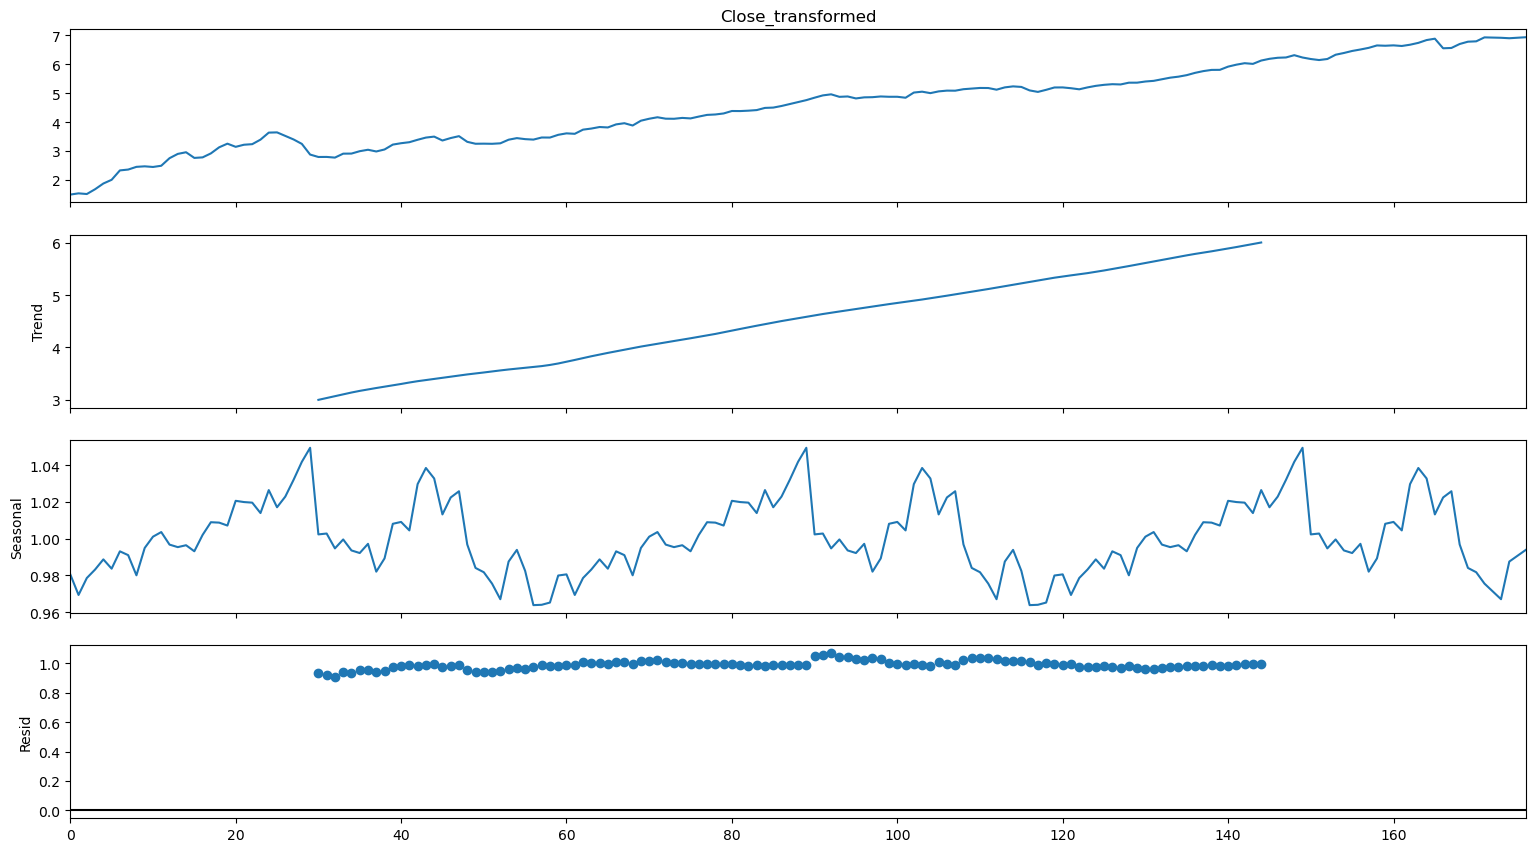

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Extract the 'Close_transformed' values from the DataFrame
time_series_data = df_without_outliers['Close_transformed']

# Decompose the time series using seasonal_decompose
result = seasonal_decompose(time_series_data, model='multiplicative', period=60)

# Plot the decomposition results
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()


Box-Cox Transformation provides better trend stationarity but still doesn't remove ADF non-stationarity

In [20]:
df_without_outliers['Close_transformed_diff'] = df_without_outliers['Close_transformed'].diff().dropna()


In [21]:
df_without_outliers['Close_transformed_diff'].dropna(inplace=True)


In [22]:
df_without_outliers.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_transformed,Close_transformed_diff
0,2006-05-31,4.091304,4.258984,3.988742,4.183167,1.445718e+08,0.0,0.0,1.493410,NaN
1,2006-06-30,4.349791,4.418757,4.273467,4.349283,2.183009e+07,0.0,0.0,1.535842,0.042433
2,2006-07-31,4.267356,4.300474,4.218285,4.257495,8.656400e+06,0.0,0.0,1.512588,-0.023254
3,2006-08-31,4.928380,5.010810,4.888055,4.954589,1.157304e+07,0.0,0.0,1.678537,0.165949
4,2006-09-30,5.859737,6.002160,5.778664,5.925599,2.016965e+07,0.0,0.0,1.876327,0.197789


In [23]:
df_without_outliers1=df_without_outliers.dropna()

In [24]:
df_without_outliers1.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_transformed,Close_transformed_diff
1,2006-06-30,4.349791,4.418757,4.273467,4.349283,2.183009e+07,0.000000,0.0,1.535842,0.042433
2,2006-07-31,4.267356,4.300474,4.218285,4.257495,8.656400e+06,0.000000,0.0,1.512588,-0.023254
3,2006-08-31,4.928380,5.010810,4.888055,4.954589,1.157304e+07,0.000000,0.0,1.678537,0.165949
4,2006-09-30,5.859737,6.002160,5.778664,5.925599,2.016965e+07,0.000000,0.0,1.876327,0.197789
5,2006-10-31,6.599203,6.737044,6.511994,6.646959,1.859959e+07,0.000409,0.0,2.004394,0.128067


In [25]:
def adf_test(series):
    """
    Perform Augmented Dickey-Fuller test and return the results.
    """
    result = adfuller(series, autolag='AIC')
    adf_output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])
    for key, value in result[4].items():
        adf_output['Critical Value (%s)' % key] = value

    return adf_output

def kpss_test(series):
    """
    Perform KPSS test and return the results.
    """
    result = kpss(series, regression='c', nlags='auto')
    kpss_output = pd.Series(result[0:3], index=['Test Statistics', 'p-value', 'Number of Lags Used'])
    for key, value in result[3].items():
        kpss_output['Critical Value (%s)' % key] = value

    return kpss_output

# Apply the ADF test to the 'Close' column
adf_output = adf_test(df_without_outliers1['Close_transformed_diff'])

# Apply the KPSS test to the log-transformed 'Close' column
kpss_output = kpss_test(df_without_outliers1['Close_transformed_diff'])

# Check for stationarity using ADF test
signif = 0.05
p_value = adf_output['p-value']

print("Results of Augmented Dickey-Fuller Test:")
print(adf_output)

if p_value <= signif:
    print("ADF test indicates that the series 'Close_transformed_diff' is stationary.")
else:
    print("ADF test indicates that the series 'Close_transformed_diff' is non-stationary.")

# Check for stationarity using KPSS test
p_value_kpss = kpss_output['p-value']

print("\nResults of KPSS Test:")
print(kpss_output)

if p_value_kpss >= signif:
    print("KPSS test indicates that the series 'Close_transformed_diff' is stationary.")
else:
    print("KPSS test indicates that the series 'Close_transformed_diff' is non-stationary.")


Results of Augmented Dickey-Fuller Test:
Test Statistics               -8.677186e+00
p-value                        4.383909e-14
No. of Lags Used               1.000000e+00
Number of Observations Used    1.720000e+02
Critical Value (1%)           -3.468952e+00
Critical Value (5%)           -2.878495e+00
Critical Value (10%)          -2.575809e+00
dtype: float64
ADF test indicates that the series 'Close_transformed_diff' is stationary.

Results of KPSS Test:
Test Statistics          0.116029
p-value                  0.100000
Number of Lags Used      2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
KPSS test indicates that the series 'Close_transformed_diff' is stationary.


/tmp/ipykernel_20/1138724058.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


<Figure size 1000x600 with 0 Axes>

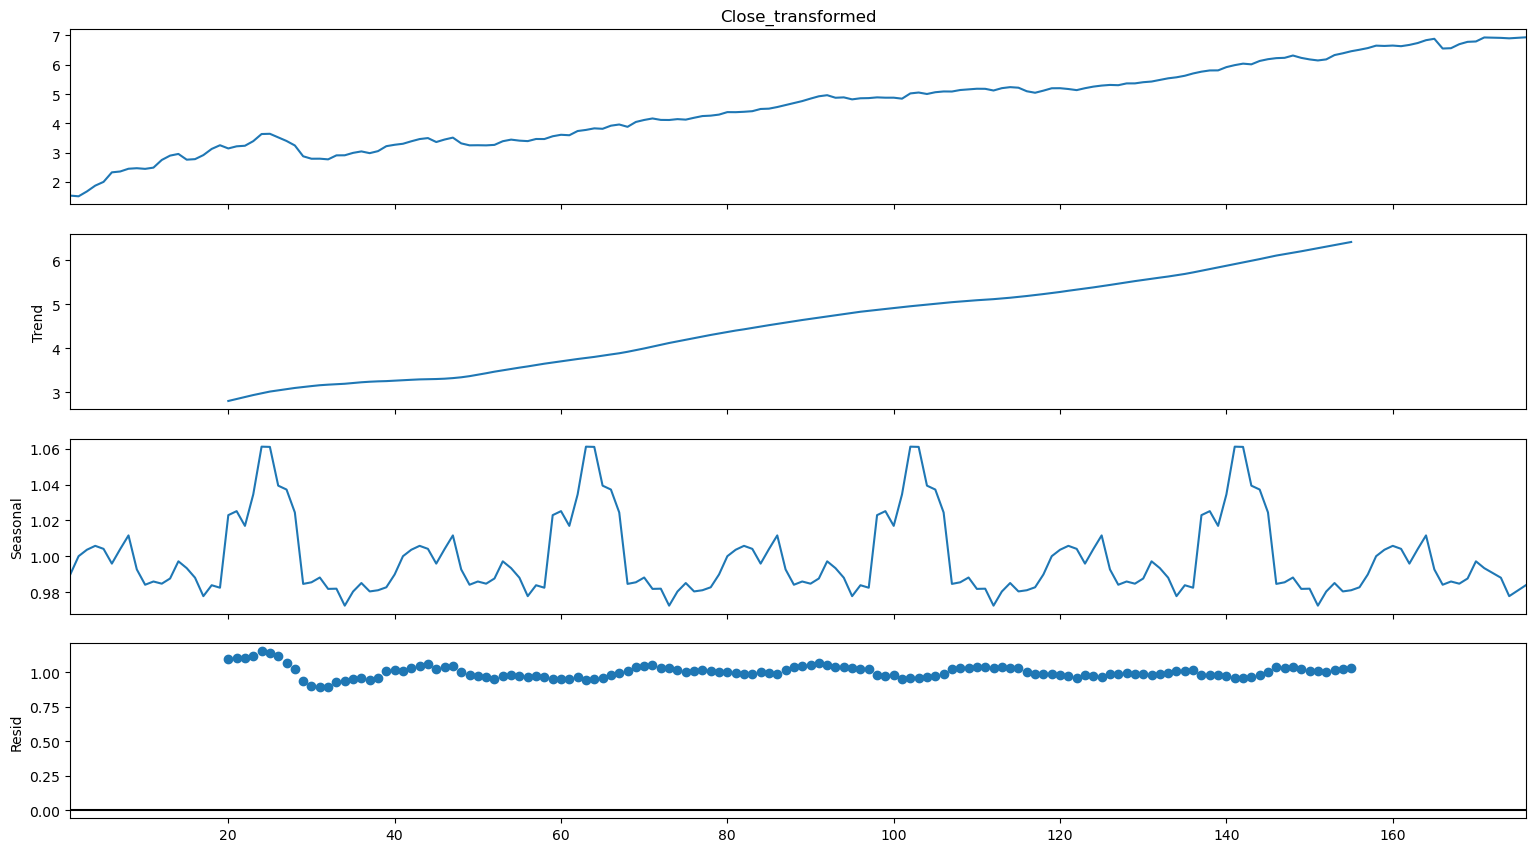

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Extract the 'Close_transformed' values from the DataFrame
time_series_data = df_without_outliers1['Close_transformed']

# Decompose the time series using seasonal_decompose
result = seasonal_decompose(time_series_data, model='multiplicative', period=39)

# Plot the decomposition results
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

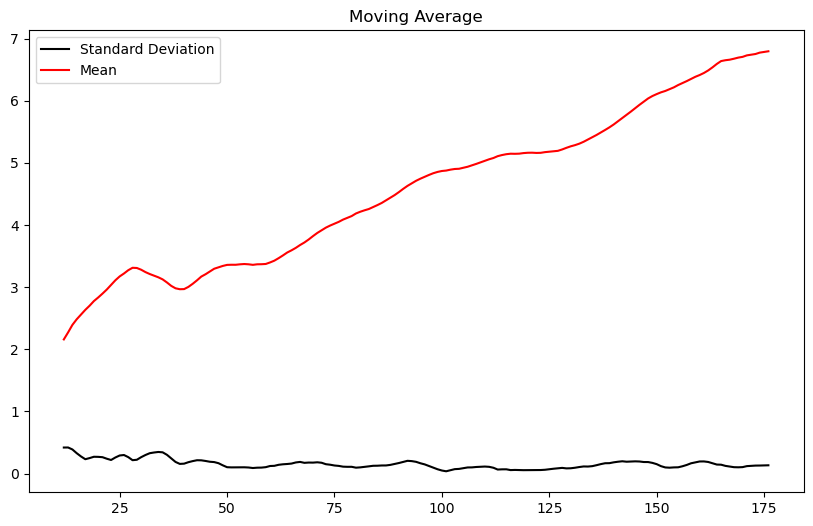

In [27]:
moving_avg = df_without_outliers1['Close_transformed'].rolling(12).mean()
std_dev = df_without_outliers1['Close_transformed'].rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


In [28]:
df_without_outliers1.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_transformed,Close_transformed_diff
1,2006-06-30,4.349791,4.418757,4.273467,4.349283,2.183009e+07,0.000000,0.0,1.535842,0.042433
2,2006-07-31,4.267356,4.300474,4.218285,4.257495,8.656400e+06,0.000000,0.0,1.512588,-0.023254
3,2006-08-31,4.928380,5.010810,4.888055,4.954589,1.157304e+07,0.000000,0.0,1.678537,0.165949
4,2006-09-30,5.859737,6.002160,5.778664,5.925599,2.016965e+07,0.000000,0.0,1.876327,0.197789
5,2006-10-31,6.599203,6.737044,6.511994,6.646959,1.859959e+07,0.000409,0.0,2.004394,0.128067


In [29]:
# Assuming your 'Datetime' column is already in the correct datetime format
df_without_outliers1.set_index('Date', inplace=True)


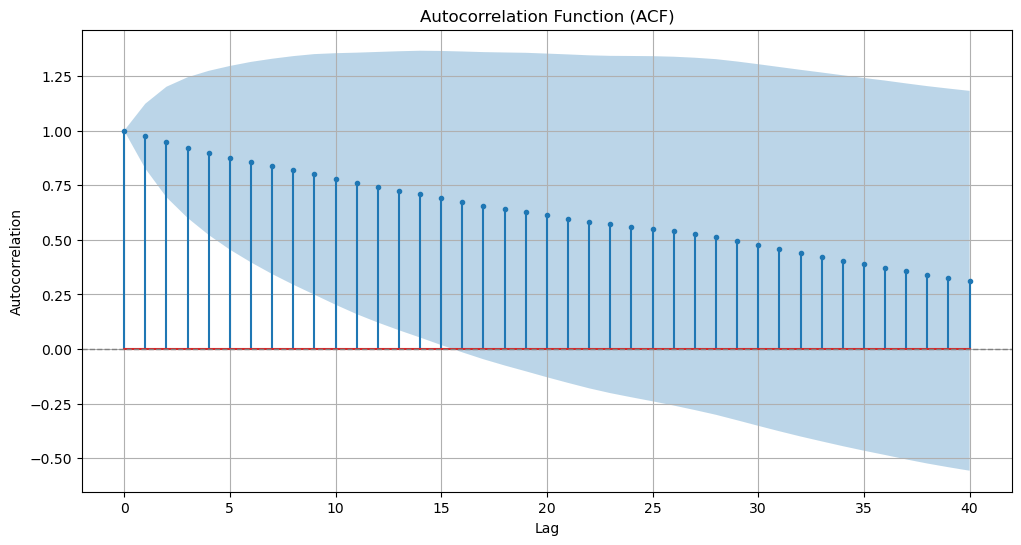

ACF Values:
Lag 0: ACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: ACF Value = 0.9748096908499132, Confidence Interval = [0.8262252  1.12339418]
Lag 2: ACF Value = 0.9481263105801384, Confidence Interval = [0.69507389 1.20117873]
Lag 3: ACF Value = 0.92243256003989, Confidence Interval = [0.60036408 1.24450104]
Lag 4: ACF Value = 0.8980838708237382, Confidence Interval = [0.52218689 1.27398085]
Lag 5: ACF Value = 0.8756538633655462, Confidence Interval = [0.45504512 1.29626261]
Lag 6: ACF Value = 0.8558699391830542, Confidence Interval = [0.39677496 1.31496492]
Lag 7: ACF Value = 0.8363081105025286, Confidence Interval = [0.34324411 1.32937211]
Lag 8: ACF Value = 0.8179875493179339, Confidence Interval = [0.29454281 1.34143229]
Lag 9: ACF Value = 0.7997150057574635, Confidence Interval = [0.24877175 1.35065826]
Lag 10: ACF Value = 0.7788088182140961, Confidence Interval = [0.20280765 1.35480999]
Lag 11: ACF Value = 0.7584932085607986, Confidence Interval = [0.15969518 1.35729124]

In [30]:
acf_values, confint_acf = acf(df_without_outliers1['Close_transformed'], nlags=40, alpha=0.05)

# Plot ACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(acf_values)), confint_acf[:, 0], confint_acf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Print ACF values with confidence intervals
print("ACF Values:")
for lag, acf_val, conf_int in zip(range(len(acf_values)), acf_values, confint_acf):
    print(f"Lag {lag}: ACF Value = {acf_val}, Confidence Interval = {conf_int}")

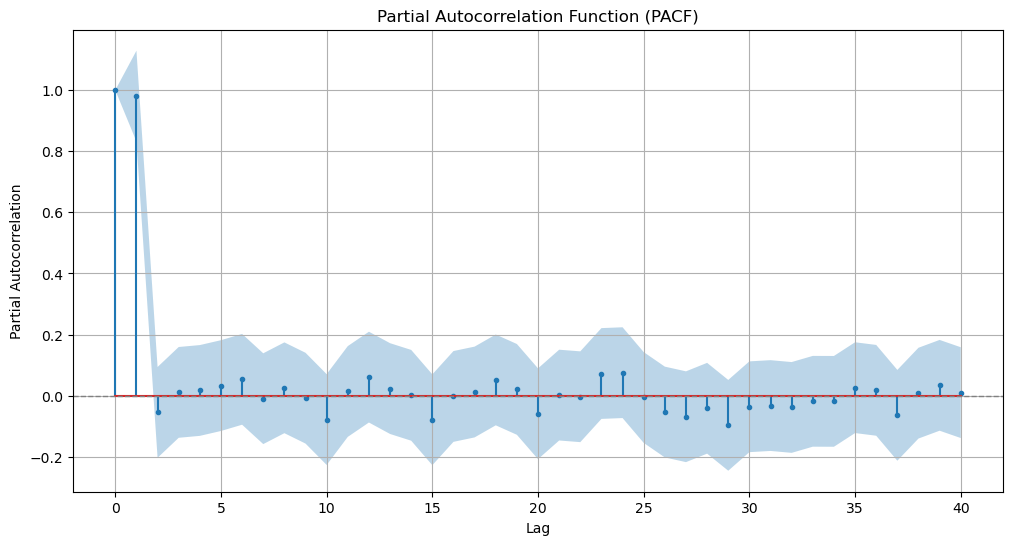

PACF Values:
Lag 0: PACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: PACF Value = 0.9804444289473114, Confidence Interval = [0.83185994 1.12902892]
Lag 2: PACF Value = -0.05474601371941661, Confidence Interval = [-0.2033305   0.09383847]
Lag 3: PACF Value = 0.010718872039717314, Confidence Interval = [-0.13786561  0.15930336]
Lag 4: PACF Value = 0.0169831703646473, Confidence Interval = [-0.13160132  0.16556766]
Lag 5: PACF Value = 0.032979734144103504, Confidence Interval = [-0.11560475  0.18156422]
Lag 6: PACF Value = 0.05348535771059849, Confidence Interval = [-0.09509913  0.20206984]
Lag 7: PACF Value = -0.009939099071551275, Confidence Interval = [-0.15852359  0.13864539]
Lag 8: PACF Value = 0.025806789140957617, Confidence Interval = [-0.1227777   0.17439128]
Lag 9: PACF Value = -0.008226319000941196, Confidence Interval = [-0.15681081  0.14035817]
Lag 10: PACF Value = -0.07818838585300482, Confidence Interval = [-0.22677287  0.0703961 ]
Lag 11: PACF Value = 0.0136891643221

In [31]:
pacf_values, confint_pacf = pacf(df_without_outliers1['Close_transformed'], nlags=40, alpha=0.05)

# Plot PACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(pacf_values)), confint_pacf[:, 0], confint_pacf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Print PACF values with confidence intervals
print("PACF Values:")
for lag, pacf_val, conf_int in zip(range(len(pacf_values)), pacf_values, confint_pacf):
    print(f"Lag {lag}: PACF Value = {pacf_val}, Confidence Interval = {conf_int}")

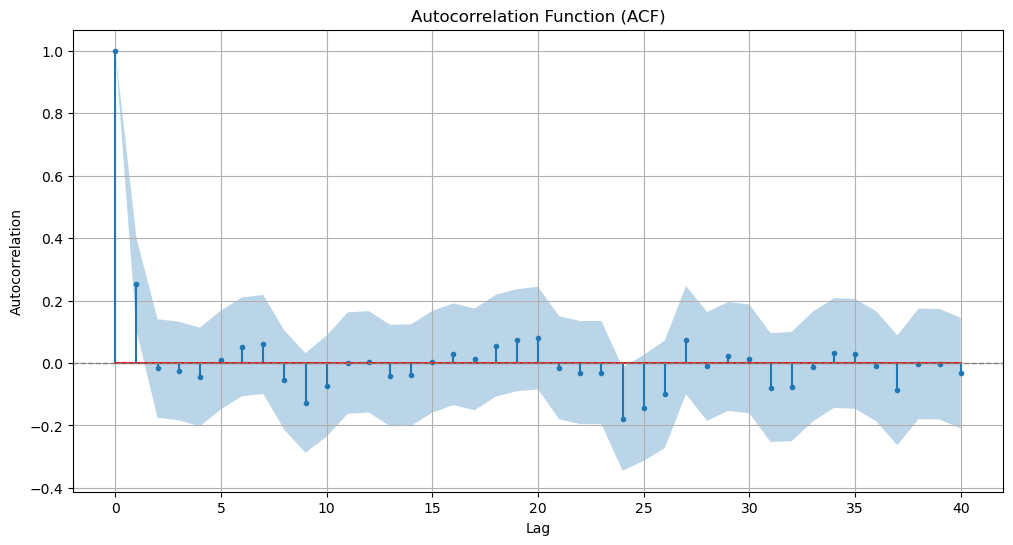

ACF Values:
Lag 0: ACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: ACF Value = 0.252684175258459, Confidence Interval = [0.10409969 0.40126866]
Lag 2: ACF Value = -0.017506675970663993, Confidence Interval = [-0.17529323  0.14027988]
Lag 3: ACF Value = -0.025482635818349187, Confidence Interval = [-0.18331206  0.13234679]
Lag 4: ACF Value = -0.04459554953471554, Confidence Interval = [-0.20251579  0.11332469]
Lag 5: ACF Value = 0.010026468864460642, Confidence Interval = [-0.14817155  0.16822449]
Lag 6: ACF Value = 0.05197299410616808, Confidence Interval = [-0.10623906  0.21018505]
Lag 7: ACF Value = 0.05960728322884036, Confidence Interval = [-0.09898125  0.21819582]
Lag 8: ACF Value = -0.05486350070909712, Confidence Interval = [-0.21394589  0.10421889]
Lag 9: ACF Value = -0.12781626092503598, Confidence Interval = [-0.28731583  0.03168331]
Lag 10: ACF Value = -0.07370653919881978, Confidence Interval = [-0.23545161  0.08803853]
Lag 11: ACF Value = 7.565496532184703e-05, Confi

In [32]:
acf_values, confint_acf = acf(df_without_outliers1['Close_transformed_diff'], nlags=40, alpha=0.05)

# Plot ACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(acf_values)), confint_acf[:, 0], confint_acf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Print ACF values with confidence intervals
print("ACF Values:")
for lag, acf_val, conf_int in zip(range(len(acf_values)), acf_values, confint_acf):
    print(f"Lag {lag}: ACF Value = {acf_val}, Confidence Interval = {conf_int}")

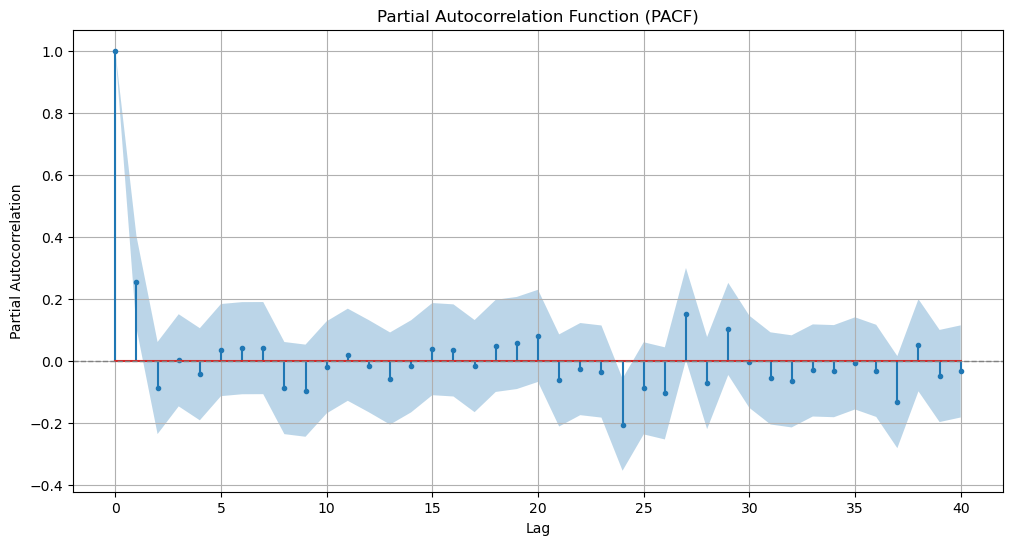

PACF Values:
Lag 0: PACF Value = 1.0, Confidence Interval = [1. 1.]
Lag 1: PACF Value = 0.254144777427583, Confidence Interval = [0.10556029 0.40272926]
Lag 2: PACF Value = -0.08798256576925524, Confidence Interval = [-0.23656705  0.06060192]
Lag 3: PACF Value = 0.0014303228137179532, Confidence Interval = [-0.14715416  0.15001481]
Lag 4: PACF Value = -0.04352727478092395, Confidence Interval = [-0.19211176  0.10505721]
Lag 5: PACF Value = 0.034393204730857746, Confidence Interval = [-0.11419128  0.18297769]
Lag 6: PACF Value = 0.04050296384365648, Confidence Interval = [-0.10808152  0.18908745]
Lag 7: PACF Value = 0.040817996652906904, Confidence Interval = [-0.10776649  0.18940248]
Lag 8: PACF Value = -0.08815039287687682, Confidence Interval = [-0.23673488  0.06043409]
Lag 9: PACF Value = -0.09657032397492901, Confidence Interval = [-0.24515481  0.05201416]
Lag 10: PACF Value = -0.02140280573866295, Confidence Interval = [-0.16998729  0.12718168]
Lag 11: PACF Value = 0.0193859553844

In [33]:
pacf_values, confint_pacf = pacf(df_without_outliers1['Close_transformed_diff'], nlags=40, alpha=0.05)

# Plot PACF with confidence intervals
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True, markerfmt='.')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.fill_between(range(len(pacf_values)), confint_pacf[:, 0], confint_pacf[:, 1], alpha=0.3)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

# Print PACF values with confidence intervals
print("PACF Values:")
for lag, pacf_val, conf_int in zip(range(len(pacf_values)), pacf_values, confint_pacf):
    print(f"Lag {lag}: PACF Value = {pacf_val}, Confidence Interval = {conf_int}")

In [34]:
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Close_transformed']

df_without_outliers2 = df_without_outliers1.copy()  # Create a copy of the original DataFrame

df_without_outliers2.drop(columns=columns, axis=1, inplace=True)


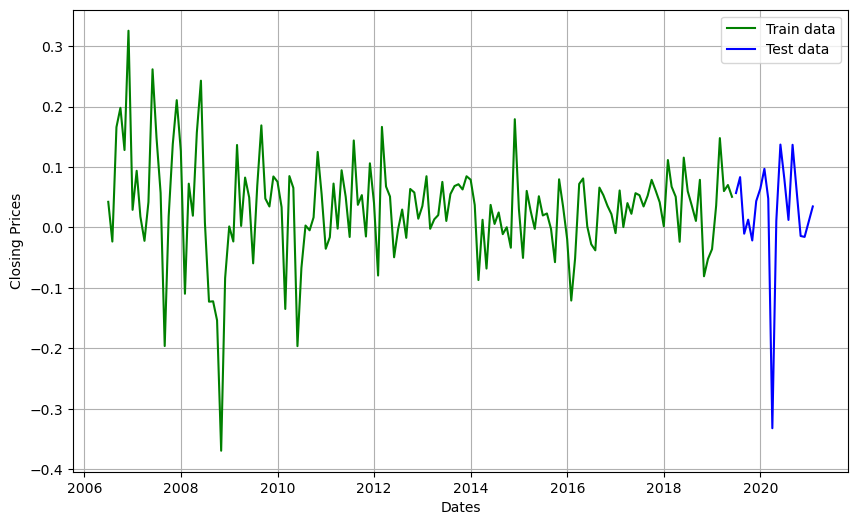

In [35]:

# Split data into train and test set
train_data = df_without_outliers2.iloc[:int(len(df_without_outliers2)*0.9)]  # Use 90% for training
test_data = df_without_outliers2.iloc[int(len(df_without_outliers2)*0.9):]  # Use the remaining 10% for testing


# Plotting the data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-305.747, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-327.815, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-325.157, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-325.856, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-325.876, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-323.817, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-336.563, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-324.954, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-334.979, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-334.986, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-336.826, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-334.963, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-332.990, Time=0.52 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.630 seconds
                      

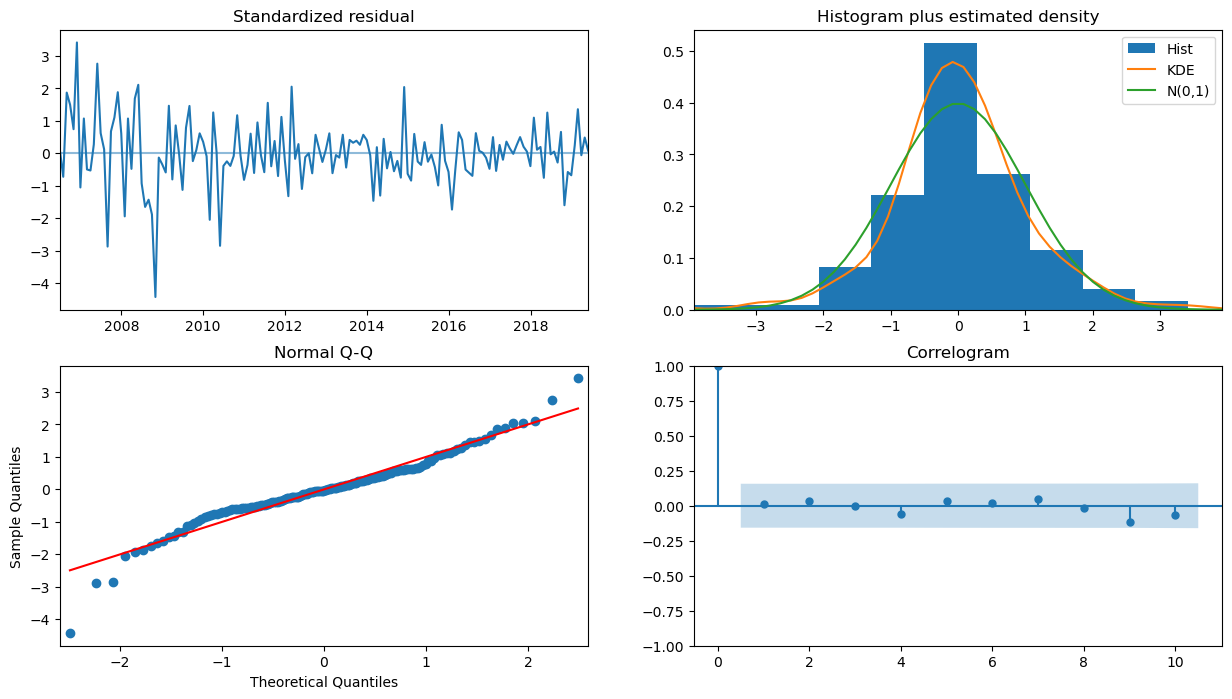

In [36]:

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',
                             max_p=3, max_q=3,
                             m=1,
                             d=None,
                             seasonal=False,
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

In [37]:
import statsmodels.api as sm



# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1, 0, 0))
fitted = model.fit()
print(fitted.summary())


                                 SARIMAX Results                                  
Dep. Variable:     Close_transformed_diff   No. Observations:                  156
Model:                     ARIMA(1, 0, 0)   Log Likelihood                 171.281
Date:                    Sun, 30 Jul 2023   AIC                           -336.563
Time:                            05:23:46   BIC                           -327.413
Sample:                        06-30-2006   HQIC                          -332.847
                             - 05-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.009      3.494      0.000       0.014       0.050
ar.L1          0.2881      0.074      3.880      0.000       0.143       0.434
sigma2         0.006

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
